In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Question 1 - Bayesian Belief Network (15 pts)

**Q1.1** (10pts) Consider the Bayes' Net over 4 Random Variables - $D,Z,T1,T2$ with the structure shown below, and joint probability distribution $P(D,Z,T1,T2)$. All the variables are binary with 1 representing "true/positive" and 0 representing "false/negative". 

![bayesnetq1.png](bayesnetq1.png)

The probabilities are given below:

P(D = 1) = 0.1   
P(D = 0) = 0.9  

P(Z = 1 | D = 1) = 0.7   
P(Z = 0 | D = 1) = 0.3  
P(Z = 1 | D = 0) = 0.8  
P(Z = 0 | D = 0) = 0.2  

P(T2 = 1 | D = 1) = 0.7           
P(T2 = 0 | D = 1) = 0.3         
P(T2 = 1 | D = 0) = 0.5     
P(T2 = 0 | D = 0) = 0.5        

P(T1 = 1 | D = 1, Z = 1) = 0.9         
P(T1 = 0 | D = 1, Z = 1) = 0.1          
P(T1 = 1 | D = 1, Z = 0) = 0.8             
P(T1 = 0 | D = 1, Z = 0) = 0.2            
P(T1 = 1 | D = 0, Z = 1) = 0.6           
P(T1 = 0 | D = 0, Z = 1) = 0.4          
P(T1 = 1 | D = 0, Z = 0) = 0.1         
P(T1 = 0 | D = 0, Z = 0) = 0.9            


a.(4pts) What is the probability of having disease D(D=1) and getting a positive result on test T1(T1=1)?   
b.(3pts) What is the probability of not having disease D(D=0) and getting a positive result on test T1(T1=1)?   
c.(3pts) What is the probability of having disease D given a positive result on test T1?   


#### Answer:



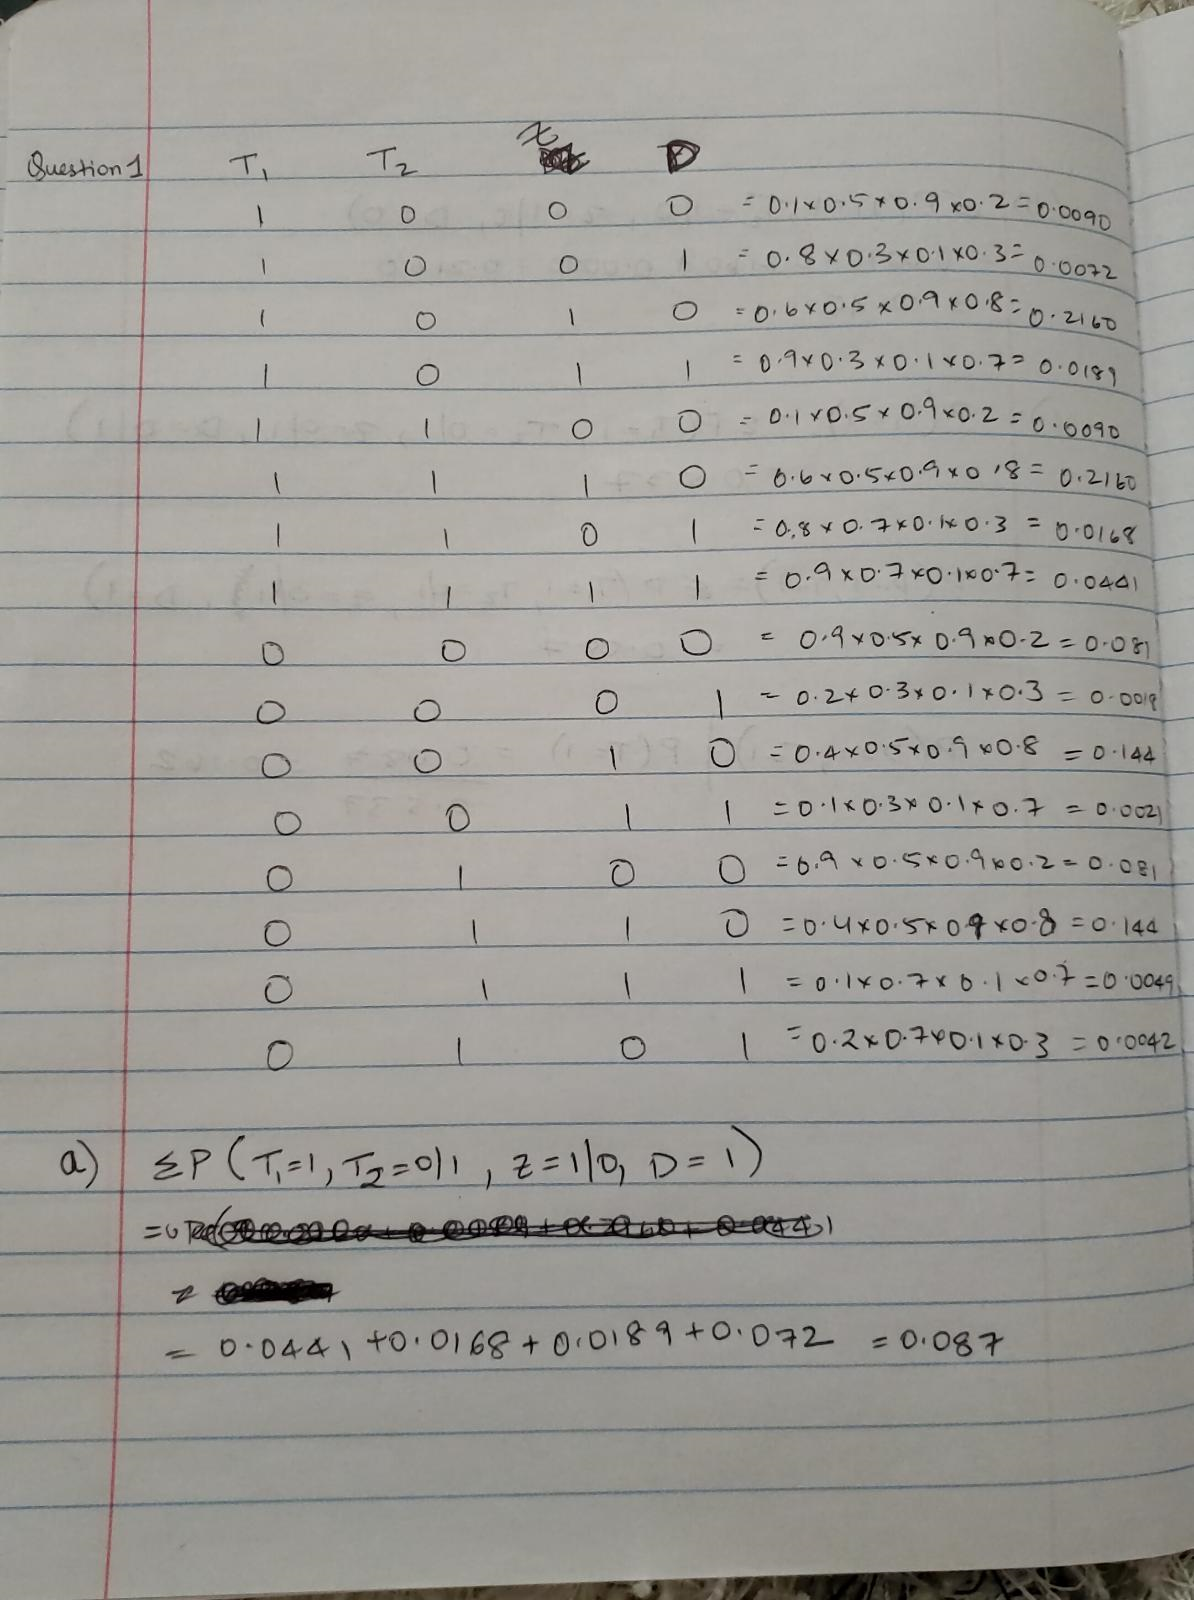

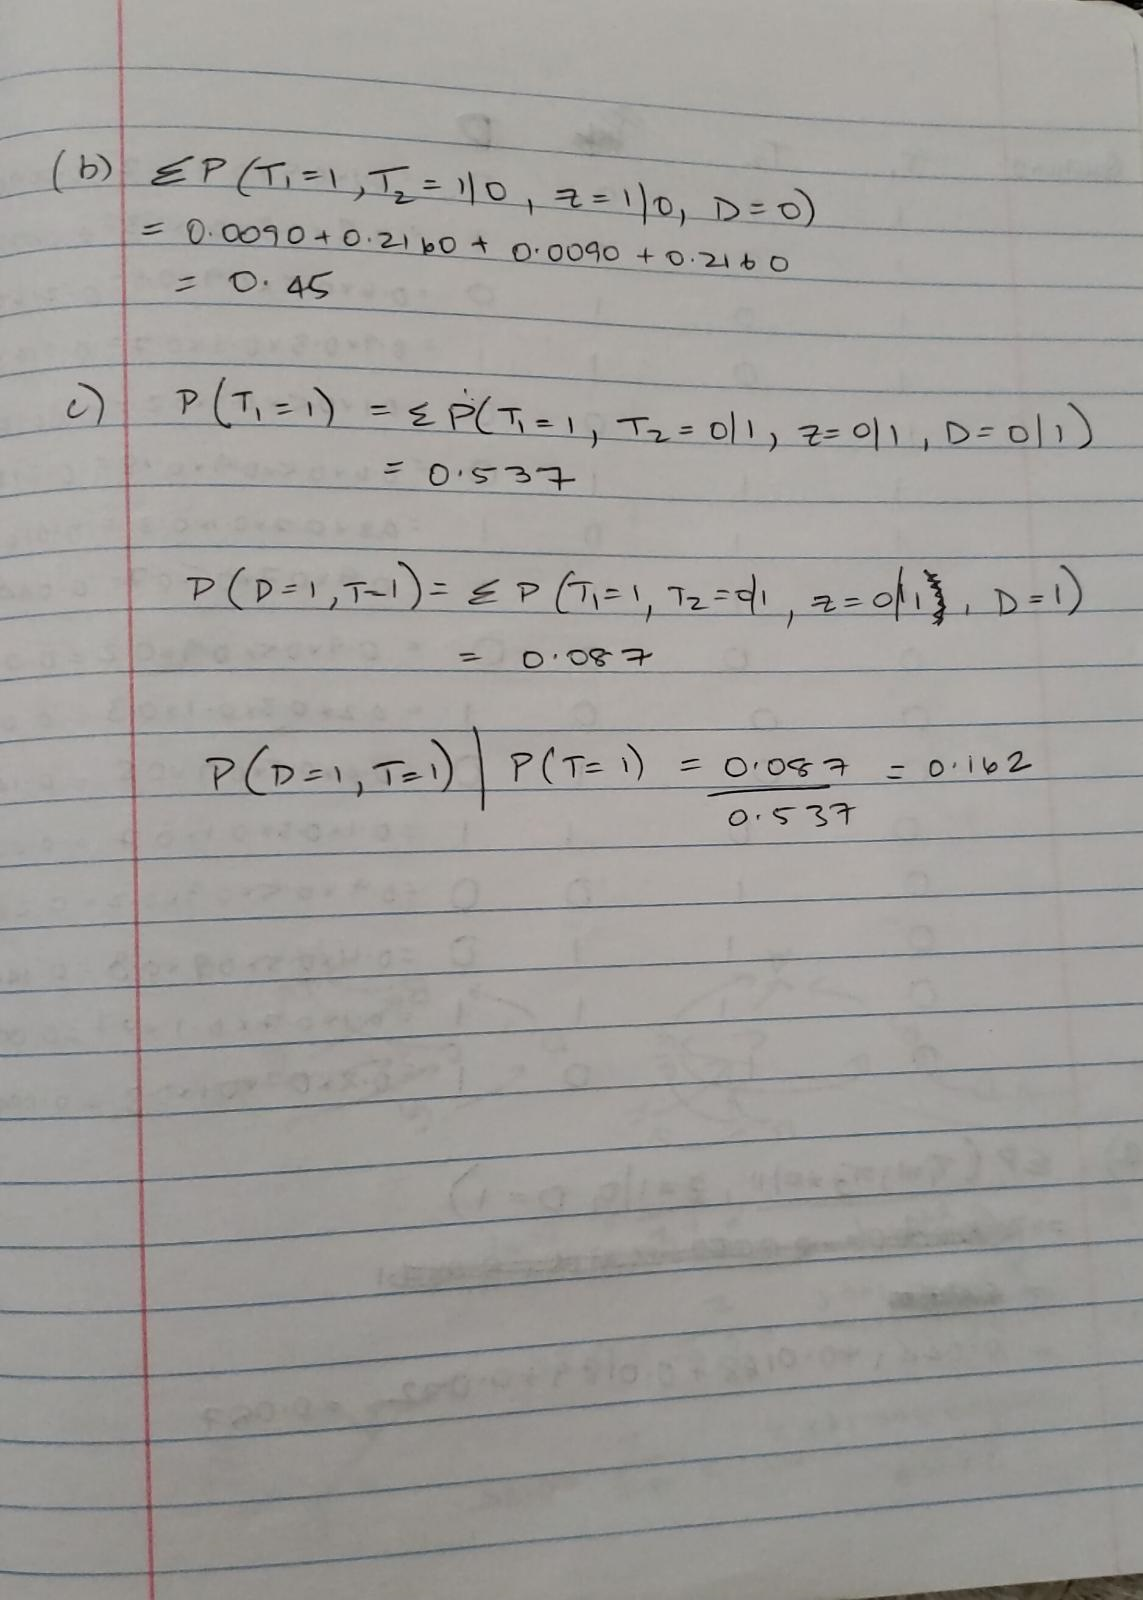

In [4]:
from IPython.display import Image
Image(filename='Q1_1.png')
Image(filename='Q1_2.png')

**Q1.2**(5pts) Draw a Bayesian Network with these Random Variables - $A, B, C, D, E, F, G, H$ whose joint distribution corresponds to -
$P(A | B,C,E) P(B | D,E) P(C | F,H) P(D | G) P(E| G,H) P(F | H) P(G) P(H)$

#### Answer:

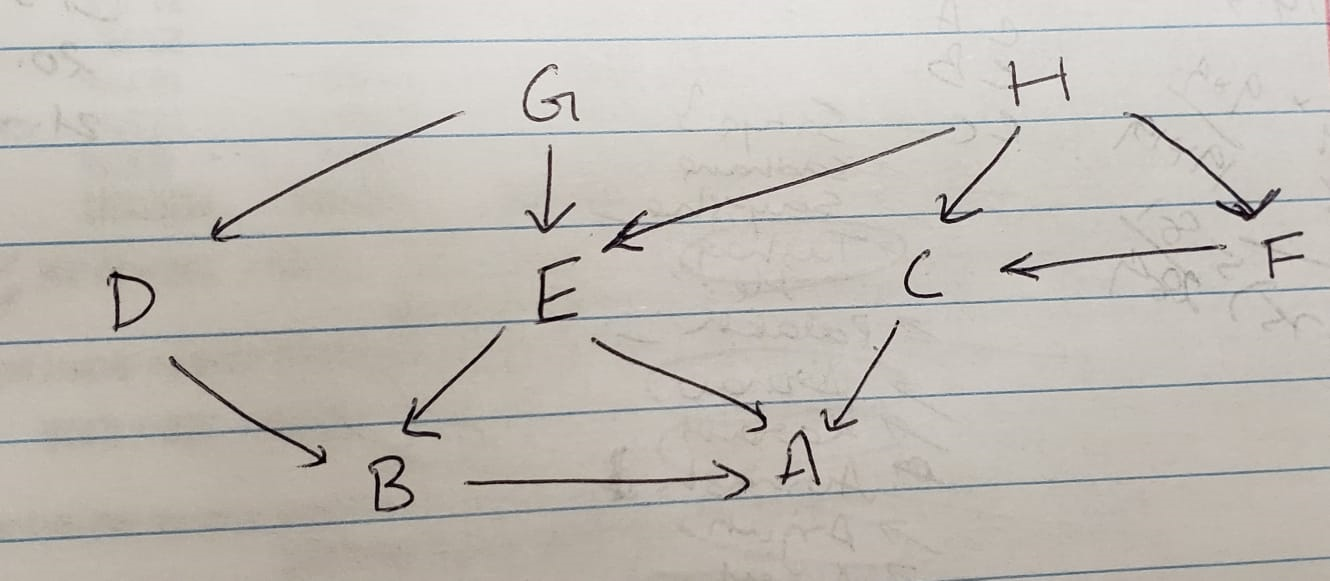

In [5]:
from IPython.display import Image
Image(filename='Q2.png')

# Question 2 - K-Nearest Neighbours and Ensemble (40pts)

In this problem, we will continue with the Churn Prediction from the last homework. You can reuse the code for pipelines which we have provided. The data has been split into train and validation sets; please do not change this.


1. Build K-Nearest Neighbours (KNN) models with different values of k ranging from 2 to 50. Plot how the train and validation AUROC varies with k. Report the best AUROC on the validation set and the corresponding value of k. (10 pts)

    We will reuse the Naive Bayes and Logistic regression models from the previous homework.
    
2. Ensemble the KNN model which obtains the best AUROC on the validation set with a Naive Bayes and Logistic regression model (with parameter class_weight='balanced') by averaging the posterior probabilities. Report the validation AUROC and F1 score. (5 pts)

3. Ensemble the KNN model which obtains the best AUROC on the validation set with a Naive Bayes and Logistic regression model (with parameter class_weight='balanced') by taking a majority vote. Report the validation F1 score. Explain why we cannot compute the AUROC in this setting. (5 pts)

    We will now compare [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), [Gradient Boosting Decision Tree](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) (GBDT), and [AdaBoost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier). 
    
4. Use a [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to classify the data. Find the best parameters (including *n_estimators*, *max_features* and *criterion*) using [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Report the optimal parameters obtained by GridSearch. Report the confusion matrix  and [roc_auc_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) on validation data. Plot the feature importance as well. (5pts)
5. Use [Gradient Boosting Decision Tree](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) (GBDT), and [AdaBoost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) for this problem. Again, find the best parameters (including *n_estimators, learning_rate,* and *max_depth (GBDT only)*), and report the confusion matrix and roc_auc_score on test data for each classifier. Also, plot the feature importance for each classifier. (10pts)
6. Point out one advantage and one disadvantage of Random Forest compared to GBDT. (5pts)

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.ensemble import RandomForestClassifier,\
GradientBoostingClassifier,AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')
from sklearn.base import BaseEstimator, TransformerMixin

class OneHotEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self,col):
        self.col = col
                
    def transform(self, X):
        return pd.get_dummies(X[self.col]) 

    def fit(self, X, y=None):
        return self    
    
# Stateless transformer for selecting a specified columns
class DFSubsetSelector(BaseEstimator,TransformerMixin):
    
    def __init__(self,cols):
        self.cols = cols
        
    def transform(self ,X):
        return X[self.cols]
    
    def fit(self, X, y=None):
        return self
    
class ConcatFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self,cols,sep="_"):
        self.cols = cols
        self.sep = sep
                
    def transform(self, X):
        concat_col = self.sep.join(self.cols)
        return X.apply(lambda x : self.sep.join([x[col] for col in self.cols]) ,axis=1).to_frame(name = concat_col)

    def fit(self, X, y=None):
        return self  
    
# Transformer that does min-max transform on the specified columns
class MinMaxTransform(BaseEstimator, TransformerMixin):

    def __init__(self,cols=None):
        self.cols = cols
        self.minVec = np.zeros(len(cols))
        self.maxVec = np.zeros(len(cols))
       
    def transform(self, X):
        X[self.cols] = ((X[self.cols] - self.minVec)/(self.maxVec-self.minVec))
        return X

    def fit(self, X, y=None):
        self.minVec = (df_train[self.cols].min())
        self.maxVec = (df_train[self.cols].max())
        return self

df = pd.read_csv('hw5.csv', delimiter=',')

#DONOT CHANGE THIS
df_train = df.sample(frac=0.8,random_state=11)
df_val = df.drop(df_train.index)


X_train = df_train.drop(['Exited'],axis=1)
y_train = df_train['Exited']
X_val= df_val.drop(['Exited'],axis=1)
y_val = df_val['Exited']

continuous_vars = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']
cat_vars = ['HasCrCard','IsActiveMember',"Geography", "Gender"] 

#building the data-processing pipeline
categorical_feature_pipeline = Pipeline([
                                       ('categorical_selector' ,DFSubsetSelector(cat_vars)),
                                        ('onehot',OneHotEncoder(cat_vars))])
numerical_feature_pipeline = Pipeline([
                                       ('numerical_selector' ,DFSubsetSelector(continuous_vars)),
                                        ('normalization',MinMaxTransform(continuous_vars))])
all_feature_preprocessor= FeatureUnion(transformer_list=[('numerical_preprocessor', numerical_feature_pipeline),
                                                      ('categorical_preprocessor', categorical_feature_pipeline)])

#### Answer

#### (1)

In [3]:
aucroc_tr = []
aucroc_te = []
for k in range(2,51,1):
    model = Pipeline(steps=[('preprocessor', all_feature_preprocessor),
                      ('classifier', knn(n_neighbors=k))])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    y_hat = model.predict(X_val)
    prob_pos_tr = model.predict_proba(X_train)[:, 1]
    aucroc_tr.append(roc_auc_score(y_train, prob_pos_tr))   
    prob_pos_te = model.predict_proba(X_val)[:, 1]
    aucroc_te.append(roc_auc_score(y_val, prob_pos_te))

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

([<matplotlib.axis.XTick at 0x2d40d7265c0>,
 <a list of 49 Text xticklabel objects>)

Text(0, 0.5, 'AUCROC')

Text(0.5, 0, 'K-Neighbours')

Text(0.5, 1.0, 'AUCROC with K')

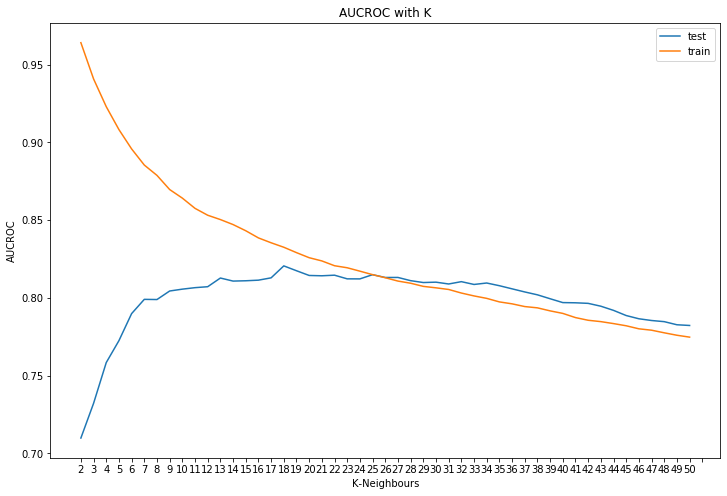

In [4]:
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(pd.Series(aucroc_te),label='test')
plt.plot(pd.Series(aucroc_tr),label='train')
plt.xticks(range(50),range(2,51,1))
plt.ylabel("AUCROC")
plt.xlabel("K-Neighbours")
plt.legend(loc='best')
plt.title("AUCROC with K")
plt.show()

In [5]:
print('Best aucroc is:', round(max(aucroc_te),2), 'with k =', aucroc_te.index(max(aucroc_te))+2 ) 

Best aucroc is: 0.82 with k = 18


#### (2)

In [6]:
gNB = Pipeline(steps=[('preprocessor', all_feature_preprocessor),
                      ('classifier', GaussianNB())])
log_reg = Pipeline(steps=[('preprocessor', all_feature_preprocessor),
                      ('classifier', LogisticRegression(class_weight='balanced'))])
k_nn = Pipeline(steps=[('preprocessor', all_feature_preprocessor),
                      ('classifier', knn(n_neighbors=18))])

model = VotingClassifier(estimators=[('knn', k_nn), ('gNB', gNB), ('log_reg', log_reg)], voting='soft')
model.fit(X_train,y_train)

VotingClassifier(estimators=[('knn',
                              Pipeline(memory=None,
                                       steps=[('preprocessor',
                                               FeatureUnion(n_jobs=None,
                                                            transformer_list=[('numerical_preprocessor',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('numerical_selector',
                                                                                                DFSubsetSelector(cols=['CreditScore',
                                                                                                                       'Age',
                                                                                                                       'Tenure',
                                                              

In [7]:
print("AUROC score is",round(roc_auc_score(y_val,model.predict_proba(X_val)[:,1]),2))
print("F1 score is",round(f1_score(y_val,model.predict(X_val)),2))

AUROC score is 0.84
F1 score is 0.52


#### (3)

#####  AUCROC cannot be used since the predicted class is the output of the majority vote exercise and not the predicted probabilities which are the necessary inputs for calculating the AUCROC score. 

In [8]:
model = VotingClassifier(estimators=[('knn', k_nn), ('gNB', gNB), ('log_reg', log_reg)], voting='hard')
model.fit(X_train,y_train)

VotingClassifier(estimators=[('knn',
                              Pipeline(memory=None,
                                       steps=[('preprocessor',
                                               FeatureUnion(n_jobs=None,
                                                            transformer_list=[('numerical_preprocessor',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('numerical_selector',
                                                                                                DFSubsetSelector(cols=['CreditScore',
                                                                                                                       'Age',
                                                                                                                       'Tenure',
                                                              

In [9]:
print("F1 score is",round(f1_score(y_val,model.predict(X_val)),2))

F1 score is 0.49


#### (4)

In [10]:
param_grid = { 
    'n_estimators': [200,300,500],
    'max_features': ['auto', 'sqrt'],
    'criterion' :['gini', 'entropy']
}
grid_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=11), param_grid=param_grid, cv= 5, scoring = 'roc_auc')
model = Pipeline(steps=[('preprocessor', all_feature_preprocessor),
                  ('classifier',grid_rf)])
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

In [11]:
print ("Best parameters for Random Forest",grid_rf.best_params_)

Best parameters for Random Forest {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 500}


In [12]:
best_model = grid_rf.best_estimator_ 
model = Pipeline(steps=[('preprocessor', all_feature_preprocessor),
                 ('classifier', best_model)])
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

In [13]:
y_hat = model.predict(X_val)
prob_pos = model.predict_proba(X_val)[:, 1]
print('Confusion matrix:')
confusion_matrix(y_val,y_hat)

Confusion matrix:


array([[1539,   48],
       [ 210,  203]], dtype=int64)

In [14]:
print("AUROC score is",round(roc_auc_score(y_val, prob_pos),2))

AUROC score is 0.89


Text(0.5, 1.0, 'Variable Importance')

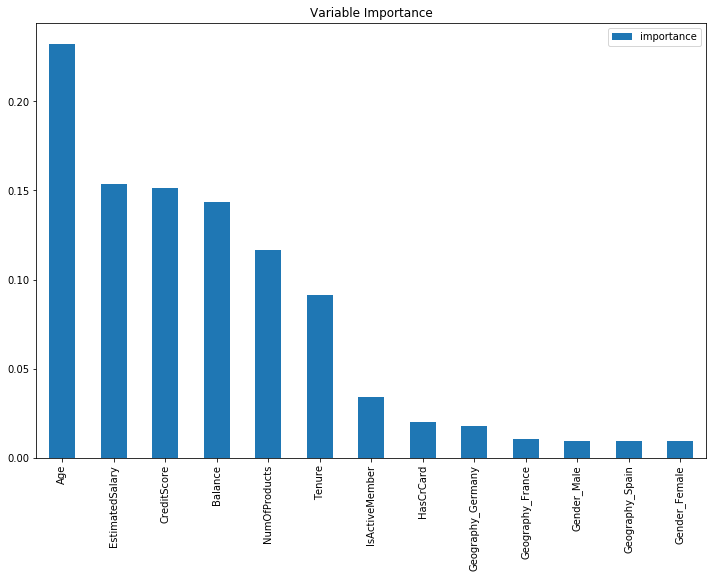

In [15]:
feature_importances = pd.DataFrame(model.steps[1][1].feature_importances_,
                                   index = ['CreditScore','Age','Tenure','Balance','NumOfProducts',
                                            'EstimatedSalary','HasCrCard','IsActiveMember',
                                            "Geography_France", "Geography_Germany", "Geography_Spain", 
                                            "Gender_Female", "Gender_Male"],
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances.plot(kind='bar')
plt.title('Variable Importance')

#### (5)

Use Gradient Boosting Decision Tree (GBDT), and AdaBoost for this problem. Again, find the best parameters (including n_estimators, learning_rate, and max_depth (GBDT only)), and report the confusion matrix and roc_auc_score on test data for each classifier. Also, plot the feature importance for each classifier. (10pts)

### Gradient Boosting

In [16]:
gbdt=GradientBoostingClassifier(random_state=11)
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    "max_depth":[3,6,8],
    "n_estimators":[200,300,500]
    }
grid_gbdt = GridSearchCV(gbdt, param_grid = param_grid, cv=5, n_jobs=-1, scoring = 'roc_auc')
model = Pipeline(steps=[('preprocessor', all_feature_preprocessor),
                  ('classifier',grid_gbdt)])
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

In [17]:
print ("Best parameters for Gradient Boosting",grid_gbdt.best_params_)

Best parameters for Gradient Boosting {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


In [18]:
best_model = grid_gbdt.best_estimator_ 
model = Pipeline(steps=[('preprocessor', all_feature_preprocessor),
                 ('classifier', best_model)])
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

In [19]:
y_hat = model.predict(X_val)
prob_pos = model.predict_proba(X_val)[:, 1]
print('Confusion matrix:')
confusion_matrix(y_val,y_hat)

Confusion matrix:


array([[1537,   50],
       [ 208,  205]], dtype=int64)

In [20]:
print("AUROC score is",round(roc_auc_score(y_val, prob_pos),2))

AUROC score is 0.89


Text(0.5, 1.0, 'Variable Importance')

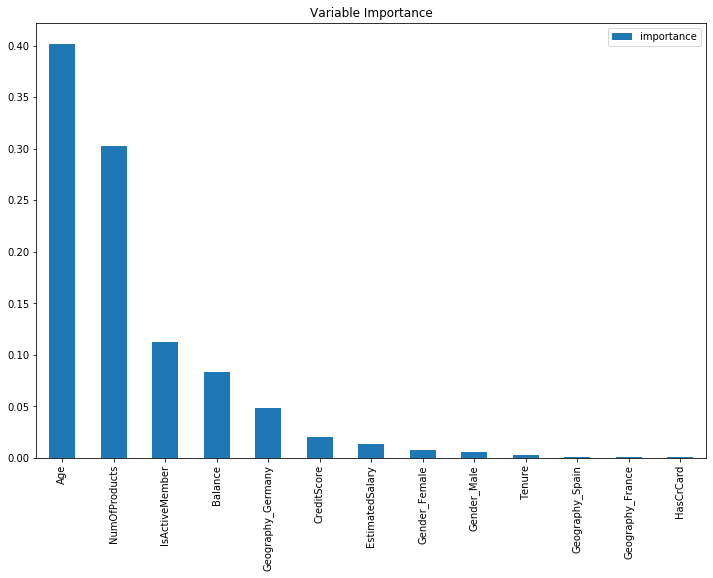

In [21]:
feature_importances = pd.DataFrame(model.steps[1][1].feature_importances_,
                                   index = ['CreditScore','Age','Tenure','Balance','NumOfProducts',
                                            'EstimatedSalary','HasCrCard','IsActiveMember',
                                            "Geography_France", "Geography_Germany", "Geography_Spain", 
                                            "Gender_Female", "Gender_Male"],
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances.plot(kind='bar')
plt.title('Variable Importance')

### AdaBoost

In [22]:
ada=AdaBoostClassifier(random_state=11)
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    "n_estimators":[200,300,500,1000],
    }
grid_ada = GridSearchCV(ada, param_grid = param_grid, cv=5, n_jobs=-1, scoring = 'roc_auc')
model = Pipeline(steps=[('preprocessor', all_feature_preprocessor),
                  ('classifier',grid_ada)])
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

In [23]:
print ("Best parameters for Adaboost",grid_ada.best_params_)

Best parameters for Adaboost {'learning_rate': 0.1, 'n_estimators': 200}


In [24]:
best_model = grid_ada.best_estimator_ 
model = Pipeline(steps=[('preprocessor', all_feature_preprocessor),
                 ('classifier', best_model)])
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerical_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('numerical_selector',
                                                                  DFSubsetSelector(cols=['CreditScore',
                                                                                         'Age',
                                                                                         'Tenure',
                                                                                         'Balance',
                                                                                         'NumOfProducts',
                                                                                         'EstimatedSalary'])),
                                                    

In [25]:
y_hat = model.predict(X_val)
prob_pos = model.predict_proba(X_val)[:, 1]
print('Confusion matrix:')
confusion_matrix(y_val,y_hat)

Confusion matrix:


array([[1537,   50],
       [ 221,  192]], dtype=int64)

In [26]:
print("AUROC score is",round(roc_auc_score(y_val, prob_pos),2))

AUROC score is 0.87


Text(0.5, 1.0, 'Variable Importance')

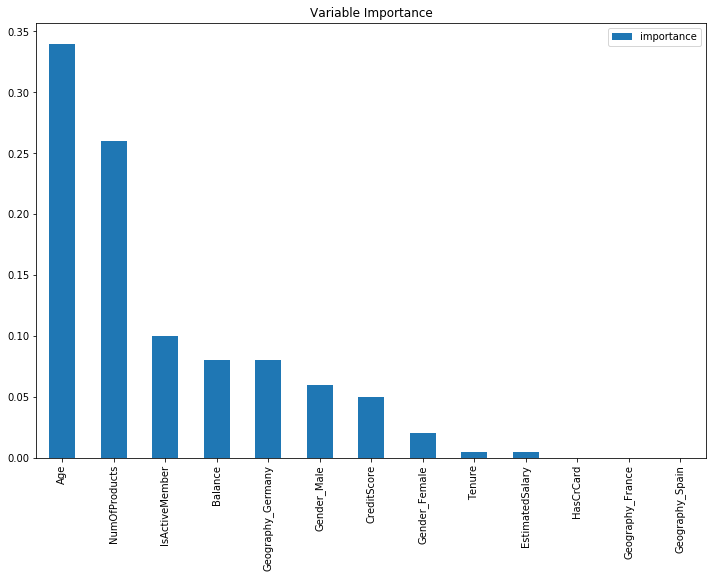

In [28]:
feature_importances = pd.DataFrame(model.steps[1][1].feature_importances_,
                                   index = ['CreditScore','Age','Tenure','Balance','NumOfProducts',
                                            'EstimatedSalary','HasCrCard','IsActiveMember',
                                            "Geography_France", "Geography_Germany", "Geography_Spain", 
                                            "Gender_Female", "Gender_Male"],#[pd.DataFrame(preprocess.transform(X_train)).columns],
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances.plot(kind='bar')
plt.title('Variable Importance')

#### (6)

Point out one advantage and one disadvantage of Random Forest compared to GBDT. (5pts)

#### Advantage of Random Forest:

In RF algorithm, trees in the ensemble can be trained parallelly unlike sequentially in GBDT as the next tree learns from the errors of the previous learner in GBDT. RF has fewer parameters to tune compared to GBDT. RF is computationally less expensive and is less prone to outliers and overfitting compared to GBDT. 

#### Disadvantage of Random Forest:

Random Forest uses fully grown decision trees (low bias, high variance). It tackles the error reduction task in the opposite way: by reducing variance. The trees are made uncorrelated to maximize the decrease in variance, but the algorithm cannot reduce bias (which is slightly higher than the bias of an individual tree in the forest). As the GBDT algorithm uses smaller trees, it has less bias. 